# Construct the forward variance curve for 15-Feb-2023


# Imports


In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
from utils import plot_ivols_mc, var_swap_robust
from fwd_var_curve import xi_curve_smooth
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Load volatility smiles from 15-Feb-2023


In [2]:
df_spx = pd.read_csv("spx_implied_vol_20230215.csv", index_col=0)
df_spx.head()

,Expiry,Texp,Strike,Bid,Ask,Fwd,CallMid
0,20230216,0.002738,1000.0,NaN,7.793085,4146.741883,NaN
1,20230216,0.002738,1200.0,NaN,6.813266,4146.741883,NaN
2,20230216,0.002738,1400.0,NaN,5.987566,4146.741883,NaN
3,20230216,0.002738,1600.0,NaN,5.273554,4146.741883,NaN
4,20230216,0.002738,1800.0,NaN,4.644049,4146.741883,NaN


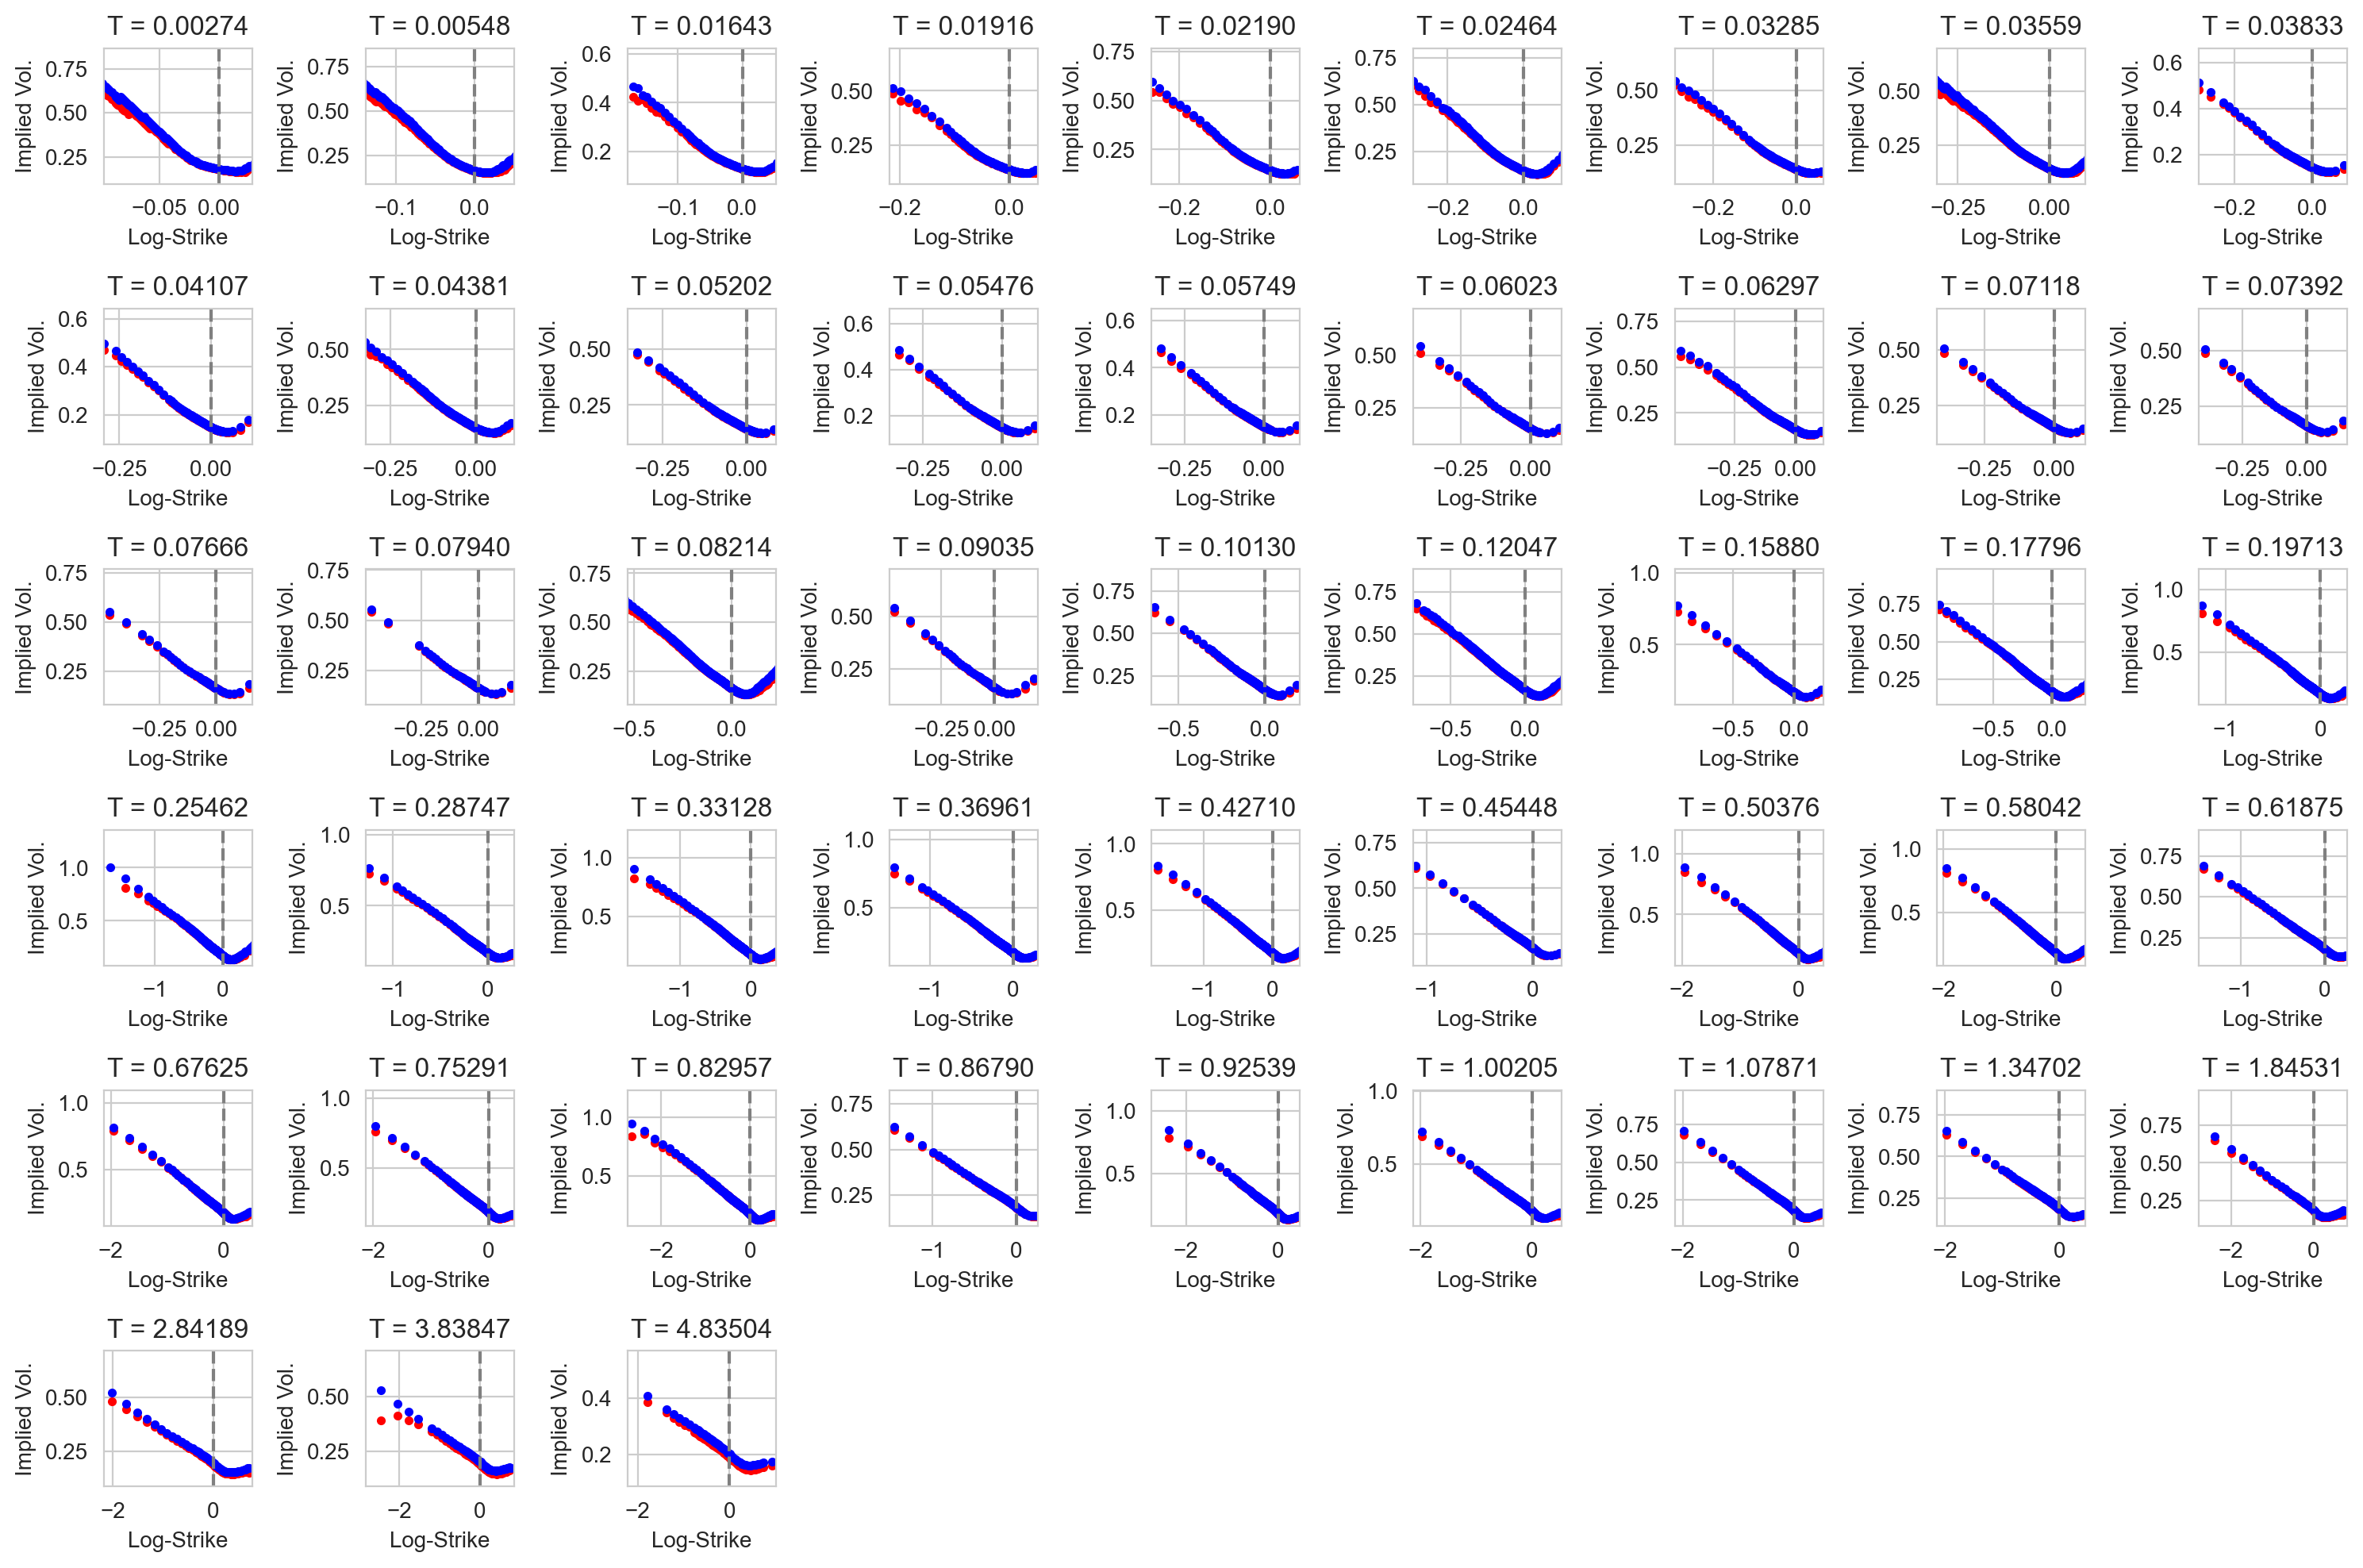

In [3]:
res_plot = plot_ivols_mc(df_spx)

Figure 1: Plot SPX smiles as of February 15, 2023.


# Robust estimation of the variance contract


In [4]:
res_vs = var_swap_robust(ivol_data=df_spx)

/Users/florianbourgey/projects/gatheral/QuadraticRoughHeston/Python/utils.py:154: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  wbar_flat = quad(PchipInterpolator(np.sort(y_in), sig_in_y**2), y_min, y_max)[0]


In [5]:
vs = res_vs["vs_mid"]

In [6]:
vs_r_code = np.array(
    [
        0.0365293285073550,
        0.03177762987481590,
        0.0198014368395580,
        0.02162057975984850,
        0.02398171428154790,
        0.02600709336247240,
        0.02304800088713060,
        0.02422691114047310,
        0.02542176218404370,
        0.02626088204329240,
        0.02728127409563520,
        0.02518733179224580,
        0.02708167589544620,
        0.02778900205509510,
        0.02838280785888840,
        0.03078455447047580,
        0.02882813652097490,
        0.03262348632761050,
        0.0330369230412840,
        0.03330855450465970,
        0.03330457782941130,
        0.03215471199799830,
        0.03728563819398170,
        0.03685265626670830,
        0.03840158851108320,
        0.03827288837696980,
        0.03897629872247960,
        0.04221298234078890,
        0.0417663245732760,
        0.04490341471205430,
        0.04532924876175550,
        0.04673886466311310,
        0.0463843062644040,
        0.04938991235307330,
        0.05067168503754370,
        0.05097511488282930,
        0.05258380206886220,
        0.05366169491978110,
        0.05525559147824150,
        0.05284341167449460,
        0.05447486235536680,
        0.05445440381891550,
        0.05493113357235020,
        0.05527497225020560,
        0.05719453730559730,
        0.05678801114856790,
        0.05711121668242890,
        0.059465108018572,
    ]
)


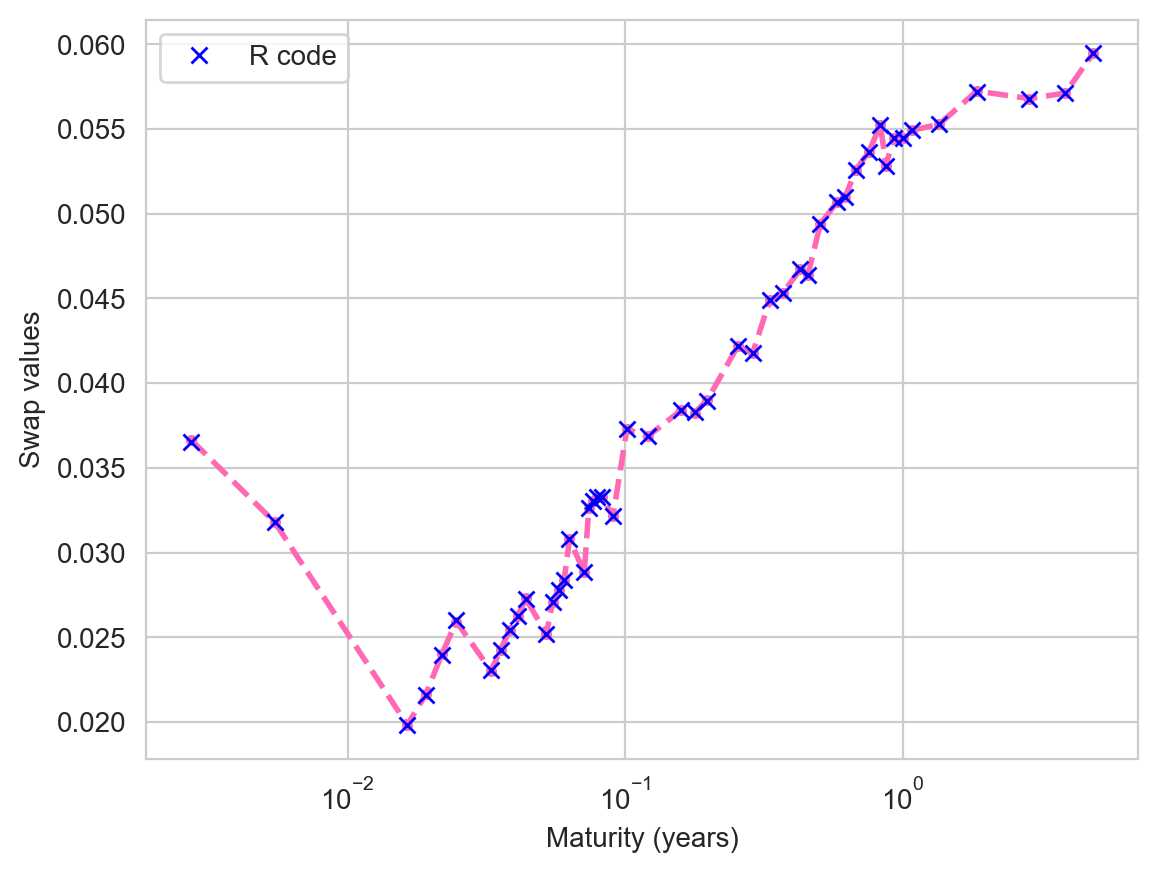

In [12]:
fig, ax = plt.subplots()
ax.plot(
    res_vs["expiries"],
    res_vs["vs_mid"],
    marker=".",
    linestyle="--",
    linewidth=2,
    color="hotpink",
)
ax.plot(res_vs["expiries"], vs_r_code, "x", color="blue", label="R code")
ax.legend()
ax.set_xlabel("Maturity (years)")
ax.set_ylabel("Swap values")
ax.set_xscale("log")
plt.show()

In [25]:
100 * (res_vs["vs_mid"] - vs_r_code) / vs_r_code

array([ 3.06934186e-01,  1.44508892e-02,  1.03117746e-01,  1.46483201e-01,
        2.51856234e-01, -2.97317599e-01, -6.43133320e-02,  1.33812078e-01,
        3.22948493e-02, -6.64006188e-03,  3.69812437e-02,  1.31506500e-02,
       -1.92088043e-02, -2.25813270e-02, -1.66072587e-02, -6.72338805e-03,
        5.76331670e-03, -6.75996311e-03, -1.96880305e-02, -4.40668780e-02,
       -2.52107230e-02, -2.46307441e-02, -7.90838008e-03,  2.31920419e-02,
       -2.69585861e-02, -1.72408200e-02,  4.31946431e-02, -4.25508567e-03,
       -5.12208362e-03, -2.93734996e-02, -1.56657717e-02, -1.86388638e-02,
       -1.33040150e-04, -6.75989304e-03,  8.80470980e-02, -3.09990013e-03,
        2.30133853e-03, -1.59990118e-02, -1.20985668e-02, -3.02215758e-03,
        1.03063137e-02,  1.65246277e-03, -2.34556005e-03,  2.40216752e-03,
        8.30189496e-02,  2.38785204e-02,  1.62758108e-02,  4.12835106e-03])

Figure 2: Log-linear plot of the forward variance curve.


# The forward variance curve from the variance curve

- By defition, $\xi_t(u) = \mathbb{E}_t[V_u]$.

- The fair value of the variance contract is given by $$ M_t(T)=\int_t^T\,\xi_t(u)\,du. $$

- Differentiating with respect to $T$ gives $$ \xi_t(T)= \partial_T M_t(T). $$


# Exact smooth forward curve construction

- In 2019, Baruch MFE student Rick Cao implemented (beautifully) a beautiful paper of [Filipović and Willems](https://arxiv.org/abs/1606.03899)

- That paper presents a non-parametric method to estimate the discount curve from market quotes, that reproduces the market quotes perfectly and has maximal smoothness in the sense that it minimizes the $L^2$-norm of the forward curve.

- We apply this method to the variance swap curve.

  - The resulting forward variance curve is piecewise quadratic.

- Warning: The resulting forward variance curve is not guaranteed to be positive - though this does not seems to matter in practice.


# Adding a bid-offer spread to smooth the curve

- In practice, `w.in` is not known exactly but only up to some bid-offer spread.

  - Moreover some expirations have more strikes than others and we get a better estimate.

- We input this bid-offer volatility spread using the `eps` parameter.


# Why the forward variance curve should be smooth

- If there are two forward variance curves that are consistent with the data, the smoother one is better.

- To see why, consider trading forward variance swaps around discontinuities in the forward curve!


In [48]:
w_in = res_vs["vs_mid"] * res_vs["expiries"]
# w_in = vs_r_code * res_vs["expiries"]
xi_smooth = xi_curve_smooth(res_vs["expiries"], w_in, eps=0.03)
xi_smooth_c = xi_smooth["xi_curve"]
xi_smooth_w_out = xi_smooth["w_out"]

A_inv [[ 3.51547966e+07 -4.75030353e+07  3.05815166e+07 ...  2.12645936e-06
  -5.93228416e-07  1.12498927e-07]
 [-4.75030353e+07  6.60825578e+07 -5.27591477e+07 ... -2.50995328e-06
   3.97748904e-07  3.72529030e-08]
 [ 3.05815174e+07 -5.27591485e+07  1.74025808e+08 ... -7.65864182e-07
   3.17056202e-06 -1.25169754e-06]
 ...
 [ 4.56095991e-07 -7.14983178e-07  1.79530007e-06 ...  1.57646527e+01
  -1.00031889e+01  2.67753576e+00]
 [-2.67962481e-07  4.11697891e-07 -1.01023770e-06 ... -1.00031889e+01
   1.00783293e+01 -3.70039679e+00]
 [ 7.86245528e-08 -1.20963455e-07  3.06266921e-07 ...  2.67753576e+00
  -3.70039679e+00  1.62707042e+00]]


In [46]:
xi_smooth_w_out

array([1.01071783e-04, 1.56123763e-04, 3.96035606e-04, 4.62365840e-04,
       5.31479456e-04, 6.03179380e-04, 8.32844211e-04, 9.13583268e-04,
       9.96014181e-04, 1.08015201e-03, 1.16597904e-03, 1.43312530e-03,
       1.52565265e-03, 1.61997872e-03, 1.71598982e-03, 1.81352976e-03,
       2.11454746e-03, 2.21754275e-03, 2.32180202e-03, 2.42728661e-03,
       2.53385632e-03, 2.86020506e-03, 3.31012584e-03, 4.13608454e-03,
       5.93149197e-03, 6.88397183e-03, 7.85134702e-03, 1.08355715e-02,
       1.25703399e-02, 1.48978194e-02, 1.69409673e-02, 2.00550174e-02,
       2.15612615e-02, 2.43363347e-02, 2.88246272e-02, 3.11303502e-02,
       3.46407309e-02, 3.93950267e-02, 4.42019292e-02, 4.66074833e-02,
       5.01884043e-02, 5.49136886e-02, 5.96387861e-02, 7.59307679e-02,
       1.04385523e-01, 1.62961732e-01, 2.23768702e-01, 2.82420119e-01])

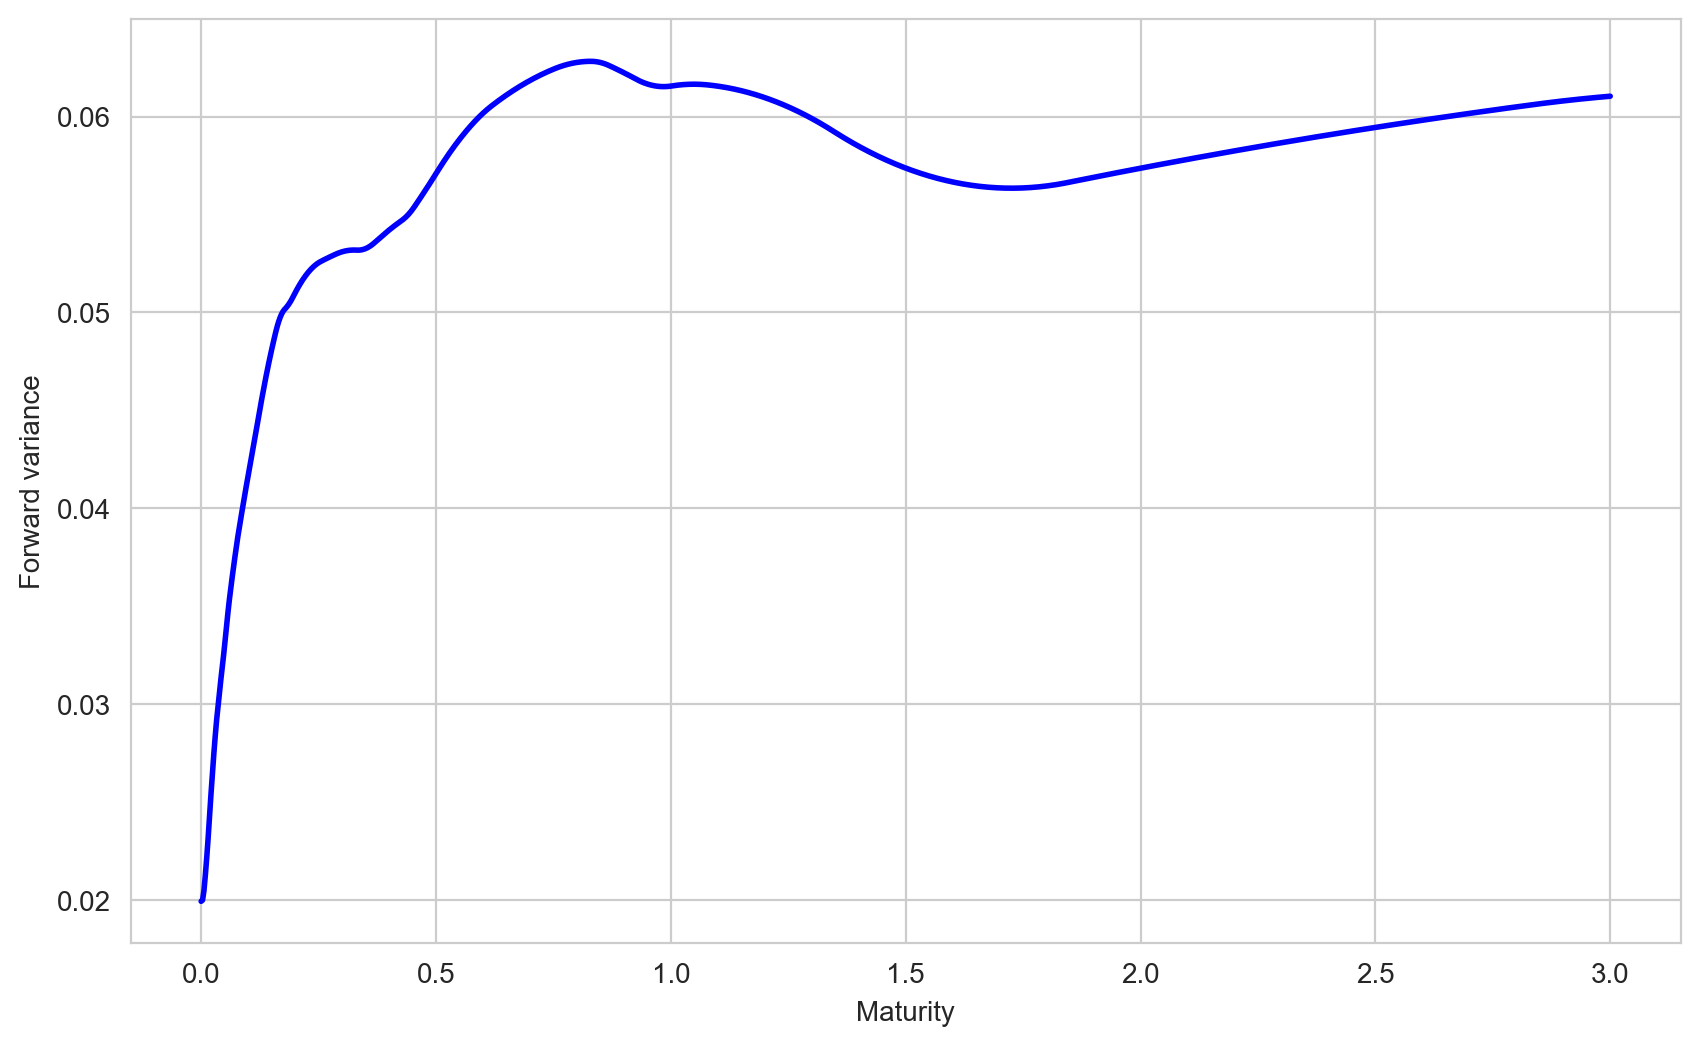

In [44]:
maturities = np.linspace(0, 3, 1000)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(maturities, xi_smooth_c(maturities), color="blue", linestyle="-", linewidth=2)
ax.set_xlabel("Maturity")
ax.set_ylabel("Forward variance")
plt.show()

In [45]:
# Draft:
u = np.linspace(0, 3, 10)
xi_smooth_c(u)

array([0.01992415, 0.05318284, 0.06137201, 0.06156285, 0.05944818,
       0.0564188 , 0.05737002, 0.05880594, 0.06005441, 0.06104601])

Figure 3: Smooth approximation to the forward variance curve. We have used a large bid//offer spread to get a smoother curve.


# What does exact interpolation mean?

- Output variance swaps exactly match input variance swaps (up to the bid-offer spread).


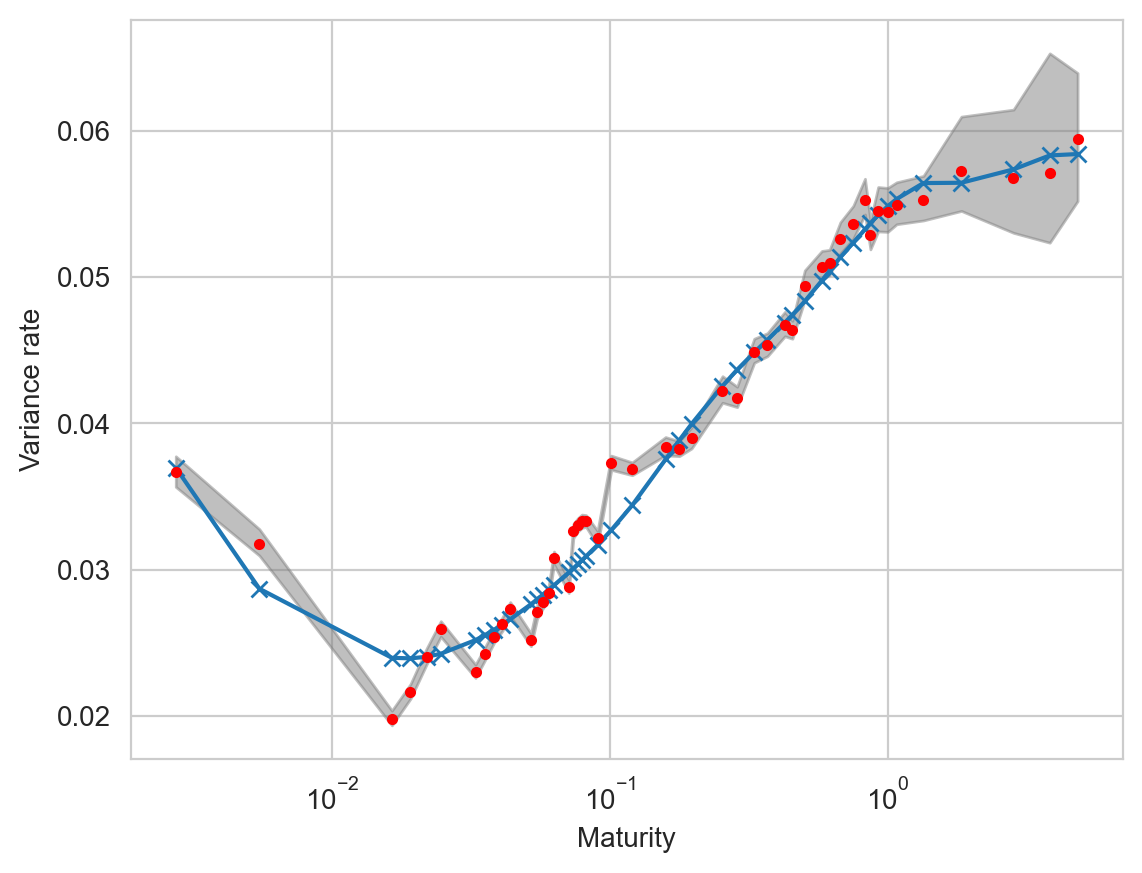

In [15]:
fig, ax = plt.subplots()
ax.plot(
    res_vs["expiries"],
    xi_smooth_w_out / res_vs["expiries"],
    marker="x",
)
# ax.vlines(
ax.fill_between(
    res_vs["expiries"],
    res_vs["vs_bid"],
    res_vs["vs_ask"],
    color="gray",
    alpha=0.5,
    label="Bid-Ask Spread",
)
ax.plot(res_vs["expiries"], res_vs["vs_mid"], "r.", label="Mid")
ax.set_xlabel("Maturity")
ax.set_ylabel("Variance rate")
ax.set_xscale("log")
plt.show()

Figure 4: Red dots are input variance contracts; blue dots are output variance swaps variance contracts.
